In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfieldSparse
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
architecture = [784, 500, 10]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([1, 0.75]), 'fb': np.array([np.nan, 0.12])}

STlambda_lr_list = [1e-6, 0.01]
sparse_layers = [1, 2]
neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 4
neural_dynamic_iterations_free = 20
hopfield_g = 0.5
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfieldSparse(architecture = architecture, lambda_ = lambda_, 
                                            epsilon = epsilon, activation = activation, sparse_layers = sparse_layers)

In [5]:
_ = evaluateContrastiveCorInfoMaxHopfieldSparse(model, train_loader, hopfield_g,
                                                neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.06143333333333333


In [6]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 30

for epoch_ in range(n_epochs):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, train_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, test_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
    print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

3000it [00:47, 63.55it/s]
1it [00:00,  6.61it/s]

Epoch : 1, Train Accuracy : 0.94195, Test Accuracy : 0.9431
Free Information ratio: [0.14555899]
Nudged Information ratio: [0.14555854]


3000it [00:47, 63.40it/s]
1it [00:00,  7.09it/s]

Epoch : 2, Train Accuracy : 0.9583333333333334, Test Accuracy : 0.9556
Free Information ratio: [0.12822477]
Nudged Information ratio: [0.12822403]


3000it [00:47, 63.71it/s]
1it [00:00,  6.52it/s]

Epoch : 3, Train Accuracy : 0.9692666666666667, Test Accuracy : 0.965
Free Information ratio: [0.14277314]
Nudged Information ratio: [0.14277207]


3000it [00:47, 63.69it/s]
1it [00:00,  7.01it/s]

Epoch : 4, Train Accuracy : 0.9728, Test Accuracy : 0.9669
Free Information ratio: [0.12085412]
Nudged Information ratio: [0.12085293]


3000it [00:47, 63.67it/s]
1it [00:00,  6.91it/s]

Epoch : 5, Train Accuracy : 0.9771833333333333, Test Accuracy : 0.9716
Free Information ratio: [0.11618959]
Nudged Information ratio: [0.11618809]


3000it [00:47, 63.63it/s]
1it [00:00,  6.53it/s]

Epoch : 6, Train Accuracy : 0.979, Test Accuracy : 0.9729
Free Information ratio: [0.11617138]
Nudged Information ratio: [0.11616948]


3000it [00:47, 63.63it/s]
1it [00:00,  7.13it/s]

Epoch : 7, Train Accuracy : 0.9811, Test Accuracy : 0.9721
Free Information ratio: [0.09069826]
Nudged Information ratio: [0.09069638]


3000it [00:47, 63.68it/s]
1it [00:00,  6.72it/s]

Epoch : 8, Train Accuracy : 0.98255, Test Accuracy : 0.9746
Free Information ratio: [0.09323971]
Nudged Information ratio: [0.09323763]


3000it [00:47, 63.60it/s]
1it [00:00,  6.83it/s]

Epoch : 9, Train Accuracy : 0.9831666666666666, Test Accuracy : 0.9748
Free Information ratio: [0.08323509]
Nudged Information ratio: [0.08323308]


3000it [00:47, 63.80it/s]
1it [00:00,  6.57it/s]

Epoch : 10, Train Accuracy : 0.9843166666666666, Test Accuracy : 0.9759
Free Information ratio: [0.10001823]
Nudged Information ratio: [0.10001607]


3000it [00:47, 63.70it/s]
1it [00:00,  6.71it/s]

Epoch : 11, Train Accuracy : 0.9850166666666667, Test Accuracy : 0.9748
Free Information ratio: [0.07260834]
Nudged Information ratio: [0.07260564]


3000it [00:47, 63.82it/s]
1it [00:00,  7.12it/s]

Epoch : 12, Train Accuracy : 0.98505, Test Accuracy : 0.9766
Free Information ratio: [0.07995519]
Nudged Information ratio: [0.07995252]


3000it [00:47, 63.70it/s]
1it [00:00,  6.87it/s]

Epoch : 13, Train Accuracy : 0.9858666666666667, Test Accuracy : 0.9757
Free Information ratio: [0.07829911]
Nudged Information ratio: [0.07829646]


3000it [00:47, 63.73it/s]
1it [00:00,  6.57it/s]

Epoch : 14, Train Accuracy : 0.98595, Test Accuracy : 0.9763
Free Information ratio: [0.07005234]
Nudged Information ratio: [0.07004967]


3000it [00:47, 63.78it/s]
1it [00:00,  6.60it/s]

Epoch : 15, Train Accuracy : 0.9869833333333333, Test Accuracy : 0.9776
Free Information ratio: [0.07184075]
Nudged Information ratio: [0.07183785]


3000it [00:47, 63.82it/s]
1it [00:00,  7.24it/s]

Epoch : 16, Train Accuracy : 0.9875166666666667, Test Accuracy : 0.9772
Free Information ratio: [0.08173439]
Nudged Information ratio: [0.08173131]


3000it [00:46, 63.88it/s]
1it [00:00,  6.79it/s]

Epoch : 17, Train Accuracy : 0.9876333333333334, Test Accuracy : 0.9777
Free Information ratio: [0.05902783]
Nudged Information ratio: [0.05902508]


3000it [00:46, 63.92it/s]
1it [00:00,  6.54it/s]

Epoch : 18, Train Accuracy : 0.98765, Test Accuracy : 0.9776
Free Information ratio: [0.07477489]
Nudged Information ratio: [0.07477175]


3000it [00:46, 63.90it/s]
1it [00:00,  6.96it/s]

Epoch : 19, Train Accuracy : 0.9875166666666667, Test Accuracy : 0.9772
Free Information ratio: [0.06198467]
Nudged Information ratio: [0.06198089]


3000it [00:47, 63.79it/s]
1it [00:00,  7.14it/s]

Epoch : 20, Train Accuracy : 0.9877666666666667, Test Accuracy : 0.9772
Free Information ratio: [0.05260591]
Nudged Information ratio: [0.05260249]


3000it [00:47, 63.46it/s]
1it [00:00,  7.05it/s]

Epoch : 21, Train Accuracy : 0.9881833333333333, Test Accuracy : 0.9777
Free Information ratio: [0.06066193]
Nudged Information ratio: [0.06065822]


3000it [00:47, 63.70it/s]
1it [00:00,  7.14it/s]

Epoch : 22, Train Accuracy : 0.9880666666666666, Test Accuracy : 0.9783
Free Information ratio: [0.05168102]
Nudged Information ratio: [0.05167741]


3000it [00:46, 63.90it/s]
1it [00:00,  6.70it/s]

Epoch : 23, Train Accuracy : 0.98815, Test Accuracy : 0.9785
Free Information ratio: [0.05180048]
Nudged Information ratio: [0.05179643]


3000it [00:47, 63.77it/s]
1it [00:00,  7.26it/s]

Epoch : 24, Train Accuracy : 0.9883333333333333, Test Accuracy : 0.9777
Free Information ratio: [0.06774638]
Nudged Information ratio: [0.06774247]


3000it [00:47, 63.62it/s]
1it [00:00,  6.91it/s]

Epoch : 25, Train Accuracy : 0.9882, Test Accuracy : 0.9779
Free Information ratio: [0.06952591]
Nudged Information ratio: [0.06952226]


3000it [00:47, 63.29it/s]
1it [00:00,  7.06it/s]

Epoch : 26, Train Accuracy : 0.9885666666666667, Test Accuracy : 0.9783
Free Information ratio: [0.06090539]
Nudged Information ratio: [0.06090133]


3000it [00:47, 63.31it/s]
1it [00:00,  6.44it/s]

Epoch : 27, Train Accuracy : 0.9885166666666667, Test Accuracy : 0.9779
Free Information ratio: [0.05517663]
Nudged Information ratio: [0.05517257]


3000it [00:47, 63.26it/s]
1it [00:00,  7.13it/s]

Epoch : 28, Train Accuracy : 0.9884666666666667, Test Accuracy : 0.9779
Free Information ratio: [0.05277401]
Nudged Information ratio: [0.05276938]


3000it [00:47, 63.18it/s]
1it [00:00,  6.88it/s]

Epoch : 29, Train Accuracy : 0.9885833333333334, Test Accuracy : 0.9792
Free Information ratio: [0.05396611]
Nudged Information ratio: [0.05396166]


3000it [00:47, 63.29it/s]


Epoch : 30, Train Accuracy : 0.9885166666666667, Test Accuracy : 0.9783
Free Information ratio: [0.06816505]
Nudged Information ratio: [0.06816057]


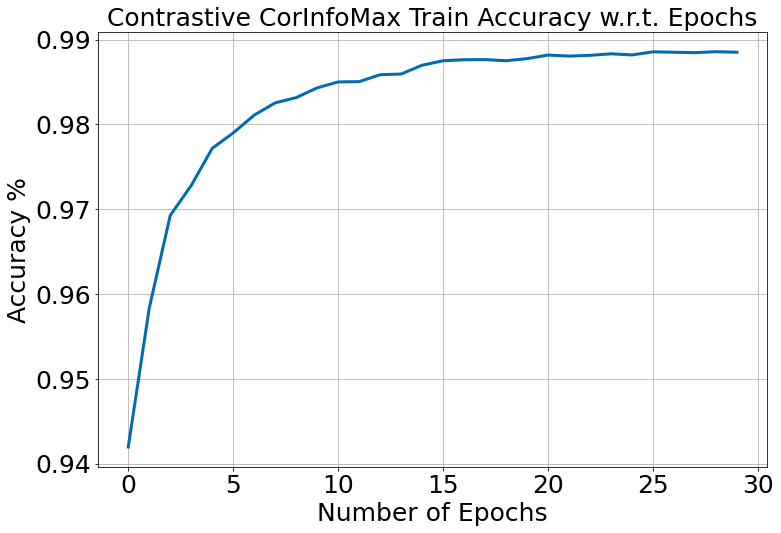

In [7]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

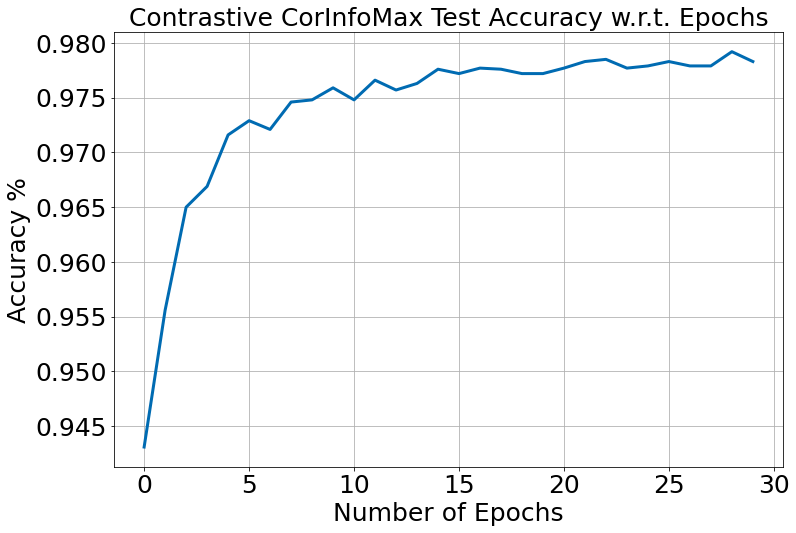

In [8]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)